In [1]:
import tarfile
import json
import bz2
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

Plot the impied probability of a runner winning against time. Here we select runners to be plotted who meet the following criteria:
they were favourites in the betting - at some time they had one of the the lowest prices, they had a large amount of bets placed on them - a relatively high volume of trades.

In [6]:
events = os.listdir('./csvs02/events/')
print(events)

DataFrameDict = {elem : pd.DataFrame() for elem in events}

for key in DataFrameDict.keys():
    DataFrameDict[key] = pd.read_csv('./csvs02/events/' + key)

['27681540.csv', '27689742.csv', '27704319.csv', '27675835.csv', '27688089.csv', '27702618.csv', '27698557.csv', '27692709.csv', '27694363.csv', '27680272.csv']


In [3]:
# Convert a time string to a time number.
def string_to_epoch(time_str):
    pattern = '%Y-%m-%dT%H:%M:%S'
    return time.mktime(time.strptime(time_str, pattern))


def plot_implied_probablility(DataFrameDict, key, inPlay):
    # Plot data inside this date range.

    if inPlay == "inPlay":

        start = DataFrameDict[key][DataFrameDict[key].inPlay == True].t.iloc[0]
        from_time = string_to_epoch(start)
        to_time = string_to_epoch(DataFrameDict[key].t.iloc[-1])
    else: 
        if inPlay == "notInPlay":
            from_time = string_to_epoch(DataFrameDict[key].t.iloc[0])
            stop = DataFrameDict[key][DataFrameDict[key].inPlay == True].t.iloc[0]
            to_time = string_to_epoch(stop)
        else:
            from_time = string_to_epoch(DataFrameDict[key].t.iloc[0])
            to_time = string_to_epoch(DataFrameDict[key].t.iloc[-1])
                

    # Make a dictionary of the lowest prices that each runner achieved.
    runner_lowest_price = {}       # Key=runner_id, Value=Lowest price they traded at.
    runner_volume = {}             # Key=runner_id, Value=Number of market change events they had.
    total_volume = 0               # Total number of market change events (total for all runners).

    # Analyse all of the runner changes for the selected market.
    # TO CHANGE: DataFrameDict[key] instead of mother_df
    for index, rc in DataFrameDict[key].iterrows():
        if (    string_to_epoch(rc['t']) >= from_time 
            and string_to_epoch(rc['t']) <= to_time):
    
            if not rc['id'] in runner_lowest_price:
                runner_lowest_price[rc['id']] = rc['ltp']
            elif rc['ltp'] < runner_lowest_price[rc['id']]:
                runner_lowest_price[rc['id']] = rc['ltp']

            if not rc['id'] in runner_volume:
                runner_volume[rc['id']] = 1
            else:
                runner_volume[rc['id']] = runner_volume[rc['id']] + 1

            total_volume += 1

    # List of colours that will be used later on for plotting lines.
    colours = ['blue', 'green', 'red', 'cyan', 'magenta']
            
    # Pick runners with lowest prices and high enough volumes, and put their keys into the best_runners list.
    # These are the runners that will have their data plotted.
    best_runners = []

    for i in range(len(runner_lowest_price)):         # All of the runners will be considered as possible to be plotted.
        # Next runner to be considered is the one who traded at the lowest price.
        best_left = min(runner_lowest_price, key=runner_lowest_price.get)
    
        if (i < len(colours)  ):                                       # Can't pick more runners than there are colours to plot.
            # and (runner_volume[best_left] / total_volume) > 0.01):   # Runner must be subject of at least 1% of the data points.
                best_runners.append(best_left)
    
        del runner_lowest_price[best_left]   
                            # Remove runner that has just been considered from the list.


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    curr_colour = 0

    sample_size = 1        # Can be adjusted to smooth out data if there are outlier prices sometimes.

    # Plot graphs for the list of best runners (lowest priced runners) found in previous cell.
    for br in best_runners:
        one_runner_x = []
        one_runner_y = []

        samples = []                          # Buffer of recent last_traded_price for this runner.
        # TO CHANGE: DataFrameDict[key] instead of mother_df
        for index, rc in DataFrameDict[key].iterrows():
            if (rc['id'] == br 
                and string_to_epoch(rc['t']) >= from_time 
                and string_to_epoch(rc['t']) <= to_time):

                if len(samples) >= sample_size:        # If the samples buffer is full...
                    del samples[0]                     # ... remove the oldest item from it.
                
                samples.append(rc['ltp'])

                # Only plot this data point if the samples buffer is full sized.
            
                one_runner_x.append(string_to_epoch(rc['t']))
                one_runner_y.append(1 / max(samples))  # Use median price paid in samples buffer.
                    # I'm not using names, it's the id instead
                one_runner_name = rc['id']

        ax.plot(one_runner_x, one_runner_y, color = colours[curr_colour], label = one_runner_name, linestyle='solid')
        curr_colour += 1

    plt.legend(loc='upper left')

    ax.set(ylabel='Implied Probability',
        # TO CHANGE: THE MARKET AND EVENT IDS FROM THE DF
        title= 'Event: ' + str(DataFrameDict[key].eventId.iloc[0]))

    # Reformat the x axis tick labels.
    x_locs, x_labels = plt.xticks()
    new_x_labels = []
    new_x_locs = []
    for l in x_locs[1:-1]:                   # Omit the first and last ticks.
        new_x_locs.append(l)
    
        # Reformat the x axis tick labels from numbers into nice date/time text format.
        new_x_labels.append(time.strftime('%d-%b-%y %H:%M', time.localtime(l)))
    plt.xticks(new_x_locs, new_x_labels)

    # Reformat the y axis tick labels.
    y_locs, y_labels = plt.yticks()
    new_y_labels = []
    new_y_locs = []
    for l in y_locs[1:-1]:                   # Omit the first and last ticks.
        new_y_locs.append(l)
    
        # Reformat the y axis tick labels from decimals into nice percentage text format.
        new_y_labels.append(str(int(l * 100)) + '%')
    plt.yticks(new_y_locs, new_y_labels)

    plt.show()

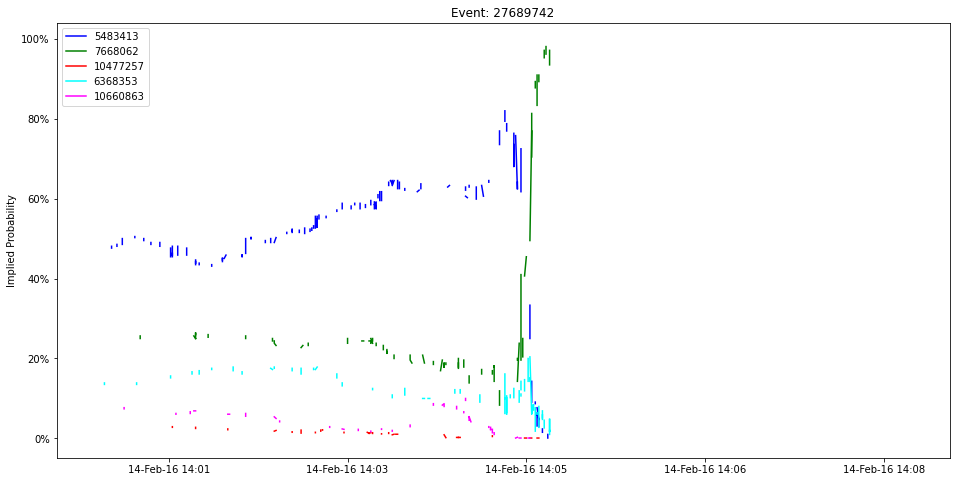

In [8]:
plot_implied_probablility(DataFrameDict, '27689742.csv', "inPlay")

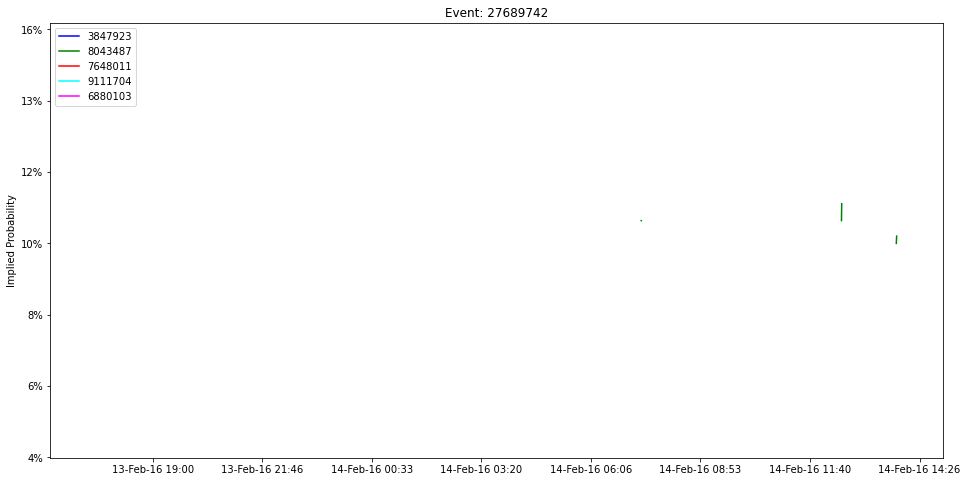

In [11]:
plot_implied_probablility(DataFrameDict, '27689742.csv', "notInPlay")

In [24]:
def plot_implied_probablility_market(DataFrameDict, key, marketId, inPlay):
    # Plot data inside this date range.

    DataFrameDict_f = DataFrameDict[key][DataFrameDict[key].marketId == marketId].copy()
   
    if inPlay == "inPlay":

        start = DataFrameDict_f[DataFrameDict_f.inPlay == True].t.iloc[0]
        from_time = string_to_epoch(start)
        to_time = string_to_epoch(DataFrameDict_f.t.iloc[-1])
    else: 
        if inPlay == "notInPlay":
            from_time = string_to_epoch(DataFrameDict_f.t.iloc[0])
            stop = DataFrameDict[DataFrameDict_f.inPlay == True].t.iloc[0]
            to_time = string_to_epoch(stop)
        else:
            from_time = string_to_epoch(DataFrameDict_f.t.iloc[0])
            to_time = string_to_epoch(DataFrameDict_f.t.iloc[-1])
                

    # Make a dictionary of the lowest prices that each runner achieved.
    runner_lowest_price = {}       # Key=runner_id, Value=Lowest price they traded at.
    runner_volume = {}             # Key=runner_id, Value=Number of market change events they had.
    total_volume = 0               # Total number of market change events (total for all runners).

    # Analyse all of the runner changes for the selected market.
    # TO CHANGE: DataFrameDict[key] instead of mother_df
    for index, rc in DataFrameDict_f.iterrows():
        if (    string_to_epoch(rc['t']) >= from_time 
            and string_to_epoch(rc['t']) <= to_time):
    
            if not rc['id'] in runner_lowest_price:
                runner_lowest_price[rc['id']] = rc['ltp']
            elif rc['ltp'] < runner_lowest_price[rc['id']]:
                runner_lowest_price[rc['id']] = rc['ltp']

            if not rc['id'] in runner_volume:
                runner_volume[rc['id']] = 1
            else:
                runner_volume[rc['id']] = runner_volume[rc['id']] + 1

            total_volume += 1

    # List of colours that will be used later on for plotting lines.
    colours = ['blue', 'green', 'red', 'cyan', 'magenta']
            
    # Pick runners with lowest prices and high enough volumes, and put their keys into the best_runners list.
    # These are the runners that will have their data plotted.
    best_runners = []

    for i in range(len(runner_lowest_price)):         # All of the runners will be considered as possible to be plotted.
        # Next runner to be considered is the one who traded at the lowest price.
        best_left = min(runner_lowest_price, key=runner_lowest_price.get)
    
        if (i < len(colours)  ):                                       # Can't pick more runners than there are colours to plot.
            # and (runner_volume[best_left] / total_volume) > 0.01):   # Runner must be subject of at least 1% of the data points.
                best_runners.append(best_left)
    
        del runner_lowest_price[best_left]   
                            # Remove runner that has just been considered from the list.


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    curr_colour = 0

    sample_size = 1        # Can be adjusted to smooth out data if there are outlier prices sometimes.

    # Plot graphs for the list of best runners (lowest priced runners) found in previous cell.
    for br in best_runners:
        one_runner_x = []
        one_runner_y = []

        samples = []                          # Buffer of recent last_traded_price for this runner.
        # TO CHANGE: DataFrameDict[key] instead of mother_df
        for index, rc in DataFrameDict_f.iterrows():
            if (rc['id'] == br 
                and string_to_epoch(rc['t']) >= from_time 
                and string_to_epoch(rc['t']) <= to_time):

                if len(samples) >= sample_size:        # If the samples buffer is full...
                    del samples[0]                     # ... remove the oldest item from it.
                
                samples.append(rc['ltp'])

                # Only plot this data point if the samples buffer is full sized.
            
                one_runner_x.append(string_to_epoch(rc['t']))
                one_runner_y.append(1 / max(samples))  # Use median price paid in samples buffer.
                    # I'm not using names, it's the id instead
                one_runner_name = rc['id']

        ax.plot(one_runner_x, one_runner_y, color = colours[curr_colour], label = one_runner_name, linestyle='solid')
        curr_colour += 1

    plt.legend(loc='upper left')

    ax.set(ylabel='Implied Probability',
        # TO CHANGE: THE MARKET AND EVENT IDS FROM THE DF
        title= 'Event: ' + str(DataFrameDict_f.eventId.iloc[0]))

    # Reformat the x axis tick labels.
    x_locs, x_labels = plt.xticks()
    new_x_labels = []
    new_x_locs = []
    for l in x_locs[1:-1]:                   # Omit the first and last ticks.
        new_x_locs.append(l)
    
        # Reformat the x axis tick labels from numbers into nice date/time text format.
        new_x_labels.append(time.strftime('%d-%b-%y %H:%M', time.localtime(l)))
    plt.xticks(new_x_locs, new_x_labels)

    # Reformat the y axis tick labels.
    y_locs, y_labels = plt.yticks()
    new_y_labels = []
    new_y_locs = []
    for l in y_locs[1:-1]:                   # Omit the first and last ticks.
        new_y_locs.append(l)
    
        # Reformat the y axis tick labels from decimals into nice percentage text format.
        new_y_labels.append(str(int(l * 100)) + '%')
    plt.yticks(new_y_locs, new_y_labels)

    plt.show()

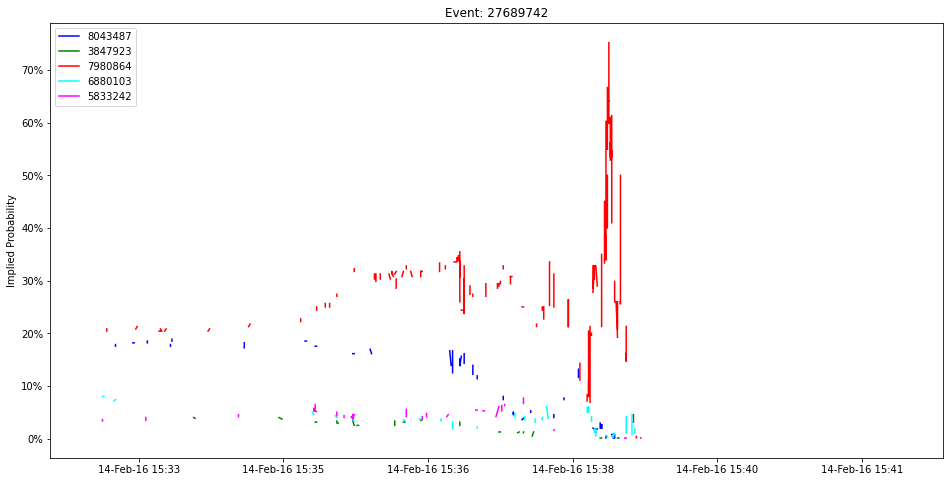

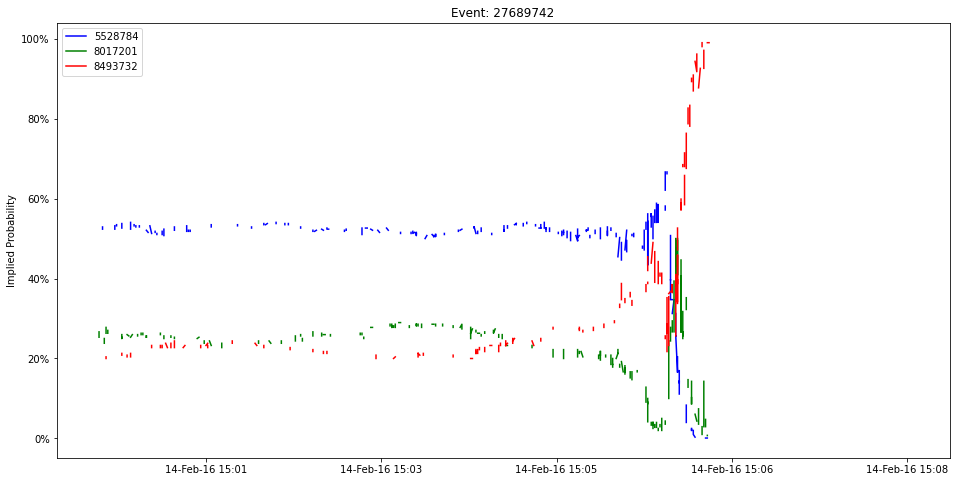

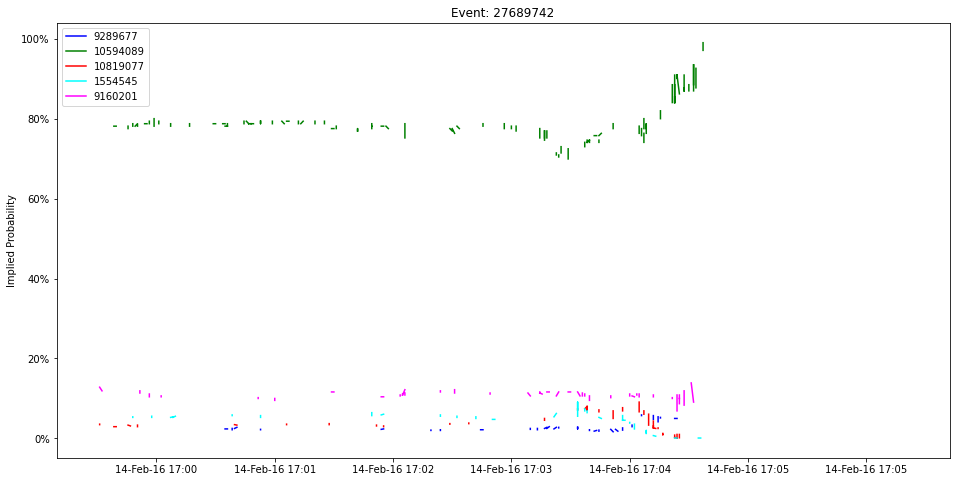

In [26]:
plot_implied_probablility_market(DataFrameDict, '27689742.csv', 1.123072435, "inPlay")
plot_implied_probablility_market(DataFrameDict, '27689742.csv', 1.123072430, "inPlay")
plot_implied_probablility_market(DataFrameDict, '27689742.csv', 1.123072450, "inPlay")
